In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'height': 768, 'scroll': True, 'width': 1024}

<h1><center>Nonlinear & Nonstationary Signal Processing with PyTFTB</center></h1>
<h2><center>by Jaidev Deshpande</center></h2>
<h3><center>PyDelhi Meetup, 9th December 2017</center></h3>


    
<div style="text-align: center"><font size="4"><strong><a href="http://twitter.com/jaidevd"><img src="images/twitter-128.png" width="32" height="32">
    </a>@jaidevd</strong></font></div>

# The Problem: Given a signal, find which frequency occured when.


### The classic problem: A Hard Day's Night
<iframe width="1280" height="541" src="https://www.youtube.com/embed/fG2evigIJIc" frameborder="0" gesture="media" allow="encrypted-media" allowfullscreen></iframe>

### The Fourier Transform:

$$ F(\omega) = \int_{-\infty}^{\infty}x(t)e^{-j\omega t}dt $$


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('grid')
from tftb.generators import fmconst
%matplotlib inline

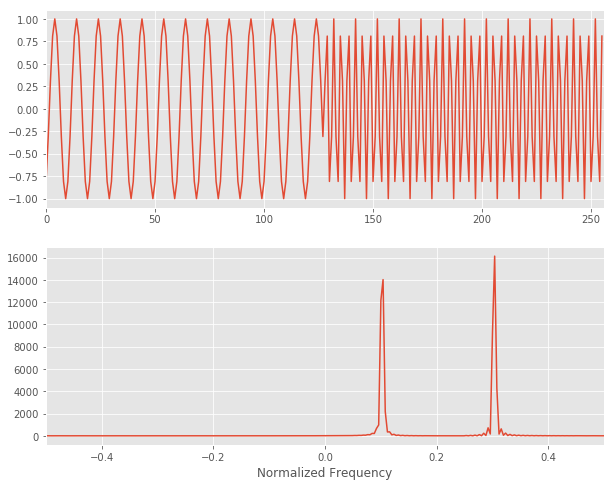

In [2]:
n_points = 128
mode1, iflaw1 = fmconst(n_points, fnorm=0.1)
mode2, iflaw2 = fmconst(n_points, fnorm=0.3)
signal = np.r_[mode1, mode2]
#plt.plot(np.real(signal))

X = np.fft.fftshift(np.fft.fft(signal))
plt.figure(figsize=(10, 8))
plt.subplot(211), plt.plot(np.real(signal)), plt.xlim(0, 256)
plt.subplot(212), plt.plot(np.linspace(-0.5, 0.5, 256), np.abs(X) ** 2)
plt.xlim(-0.5, 0.5)
plt.xlabel("Normalized Frequency")

# Time-Frequency representations of the Signal

## Short-time Fourier Transform

$$ X(\tau, \omega) = \int_{-\infty}^{\infty}x(t)w(t-\tau)e^{-j\omega t}dt$$

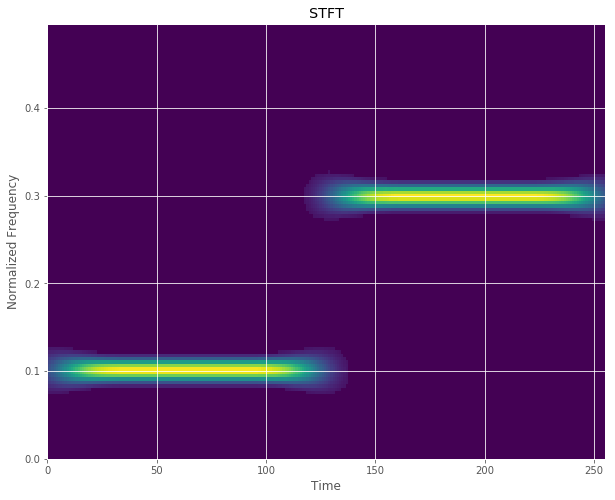

In [3]:
from tftb.processing import ShortTimeFourierTransform
stft = ShortTimeFourierTransform(signal)
stft.run()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
stft.plot(ax=ax)

![](images/intro_tf_grid.png)

# A counterexample

(0, 256)

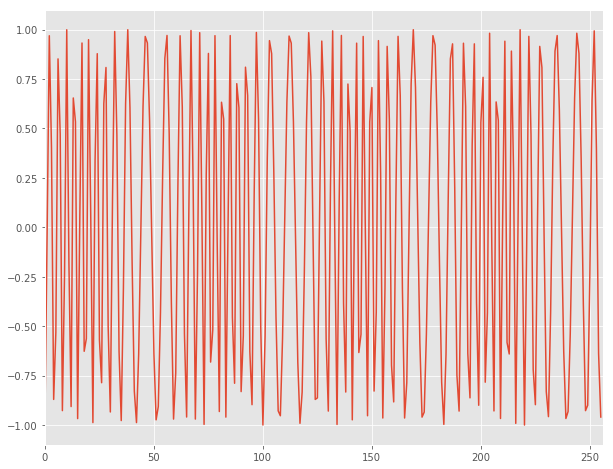

In [4]:
from tftb.generators import fmsin
sig, iflaw = fmsin(256, 0.1, 0.3, period=64)
plt.figure(figsize=(10, 8))
plt.plot(np.real(sig))
plt.xlim(0, 256)

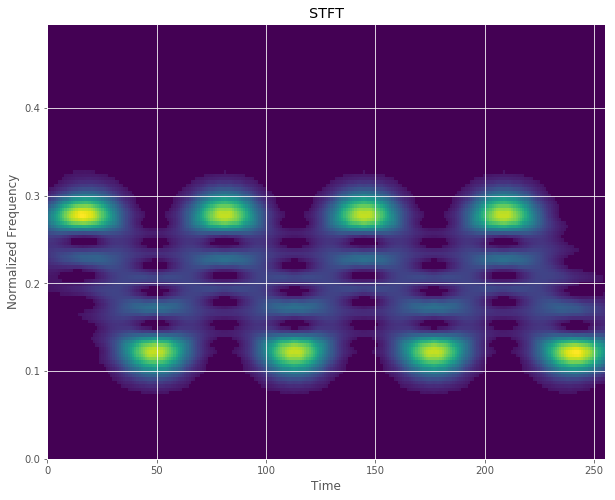

In [5]:
stft = ShortTimeFourierTransform(sig)
stft.run()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
stft.plot(ax=ax)

# The Uncertainty Principle / Heisenberg-Gabor Inequality

> The Uncertainty principle is a statement about two variables whose associated operators do not commute

\- Leon Cohen

For any two quantities $a$ and $b$, and two linear operations $f_{a}$ and $f_{b}$, the uncertainty principle can be expressed as:

$$ \Delta a \times \Delta b \geq \left\|\langle f_{a}, f_{b}\rangle \right\| $$

where $\Delta$ denotes the standard deviation.

If $T$ and $B$ are standard deviations of the time characteristics and the bandwidth respectively of a signal $s(t)$, then

$$ TB≥1 $$

# An Example

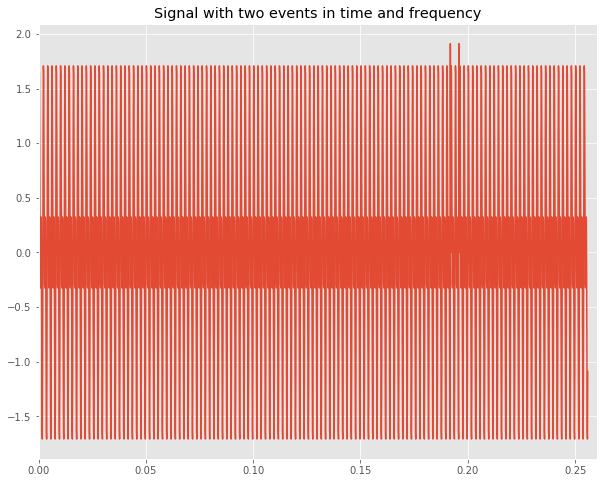

In [6]:
f1, f2 = 500, 1000
t1, t2 = 0.192, 0.196
f_sample = 8000
n_points = 2048
ts = np.arange(n_points, dtype=float) / f_sample
signal = np.sin(2 * np.pi * f1 * ts) + np.sin(2 * np.pi * f2 * ts)
signal[int(t1 * f_sample) - 1] += 3
signal[int(t2 * f_sample) - 1] += 3
plt.figure(figsize=(10, 8))
plt.plot(ts, signal)
plt.xlim([0, 0.26])
plt.title("Signal with two events in time and frequency")

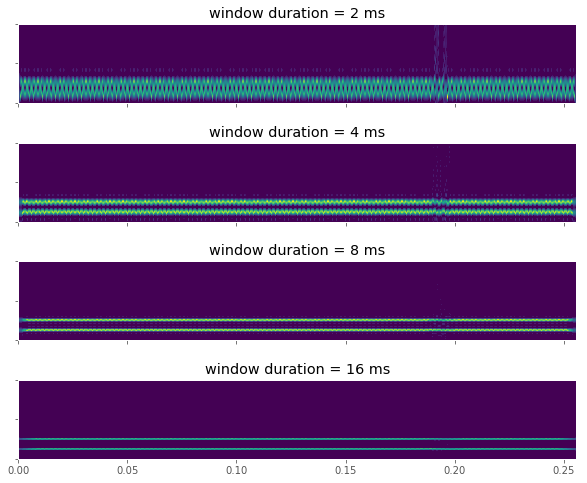

In [7]:
f1, f2 = 500, 1000
t1, t2 = 0.192, 0.196
f_sample = 8000
n_points = 2048
ts = np.arange(n_points, dtype=float) / f_sample
signal = np.sin(2 * np.pi * f1 * ts) + np.sin(2 * np.pi * f2 * ts)
signal[int(t1 * f_sample) - 1] += 3
signal[int(t2 * f_sample) - 1] += 3

wlengths = [2, 4, 8, 16]
nf = [(w * 0.001 * f_sample) + 1 for w in wlengths]
fig = plt.figure(figsize=(10, 8))
extent = [0, ts.max(), 0, 2000]
for i, wlen in enumerate(wlengths):
    window = np.ones((int(nf[i]),), dtype=float)
    stft = ShortTimeFourierTransform(signal, fwindow=window)
    stft.run()
    ax = fig.add_subplot(4, 1, i + 1)
    stft.plot(ax=ax, default_annotation=False, show=False,
              extent=extent)
    ax.set_yticklabels([])
    ax.grid(False)
    if i != 3:
        ax.set_xticklabels([])
    ax.set_title("window duration = {} ms".format(wlen))
plt.subplots_adjust(hspace=0.5)
plt.show()

# Instantaneous Frequency

## A somewhat controversial definition

For a signal $x(t)$, define the _analytic_ function

$$ x_{a}(t) = x(t) + j\widehat{x(t)} $$

Then the instantaneous frequency $\nu_{inst}$ can be defined as:

$$ \nu(i) = \frac{1}{2\pi}\frac{d}{dt}arctan[x_{a}(t)] $$

# How estimating $\nu_{inst}$ can be misleading

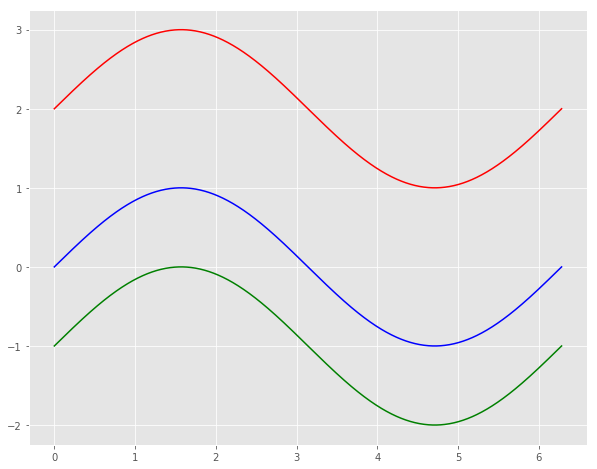

In [8]:
x = np.linspace(0, 2 * np.pi, 1000)
s1 = np.sin(x)
s2 = np.sin(x) - 1
s3 = np.sin(x) + 2
plt.figure(figsize=(10, 8))
plt.plot(x, s1, 'b', x, s2, 'g', x, s3, 'r')

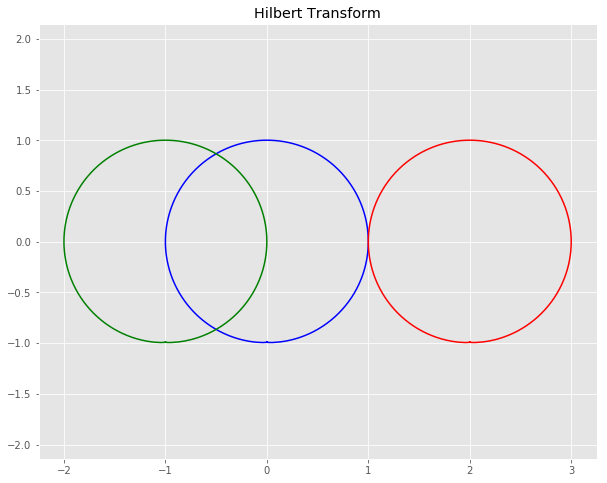

In [9]:
from scipy.signal import hilbert
hs1 = hilbert(s1)
hs2 = hilbert(s2)
hs3 = hilbert(s3)
plt.figure(figsize=(10, 8))
plt.plot(np.real(hs1), np.imag(hs1), 'b')
plt.plot(np.real(hs2), np.imag(hs2), 'g')
plt.plot(np.real(hs3), np.imag(hs3), 'r')
plt.title("Hilbert Transform")
plt.axes().set_aspect('equal', 'datalim')

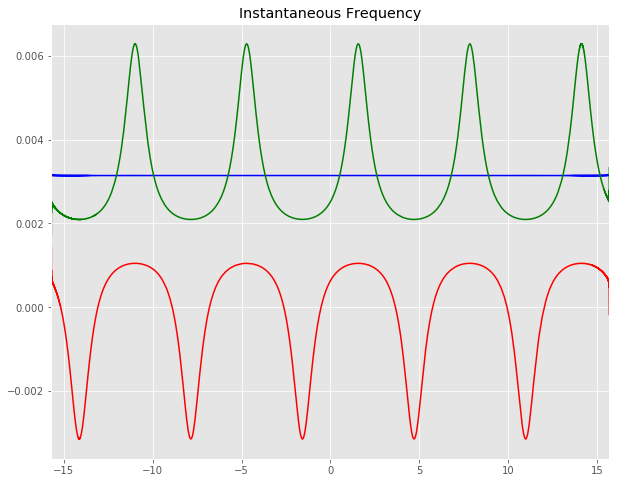

In [10]:
from scipy import angle, unwrap
from math import pi
x = np.linspace(-5 * pi, 5 * pi, 10000)
s1 = np.sin(x)
s2 = np.sin(x) - 0.5
s3 = np.sin(x) + 2
hs1 = hilbert(s1)
hs2 = hilbert(s2)
hs3 = hilbert(s3)
omega_s1 = unwrap(angle(hs1))  # unwrapped instantaneous phase
omega_s2 = unwrap(angle(hs2))
omega_s3 = unwrap(angle(hs3))
f_inst_s1 = np.diff(omega_s1)  # instantaneous frequency
f_inst_s2 = np.diff(omega_s2)
f_inst_s3 = np.diff(omega_s3)
plt.figure(figsize=(10, 8))
plt.plot(x[1:], f_inst_s1, "b")
plt.plot(x[1:], f_inst_s2, "g")
plt.plot(x[1:], f_inst_s3, "r")
plt.xlim(-5 * np.pi, 5 * np.pi)
plt.title("Instantaneous Frequency")
plt.show()

# Therefore, Intrinsic Mode Functions (IMF)

A function is called an intrinsic mode function when:

1. The number of its extrema and zero-crossings differ at most by unity.
2. The mean of the local envelopes defined by it’s local maxima and that defined by its local minima should be zero at all times.

# Empirical Mode Decomposition

1. Find all local extrema in the signal.
2. Join all the local maxima with a cubic spline, creating an upper envelope. Repeat for local minima and create a lower envelope.
3. Calculate the mean of the envelopes.
4. Subtract mean from original signals.
5. Repeat steps 1-4 until result is an IMF.
6. Subtract this IMF from the original signal.
7. Repeat steps 1-6 till there are no more IMFs left in the signal.


# EMD Example

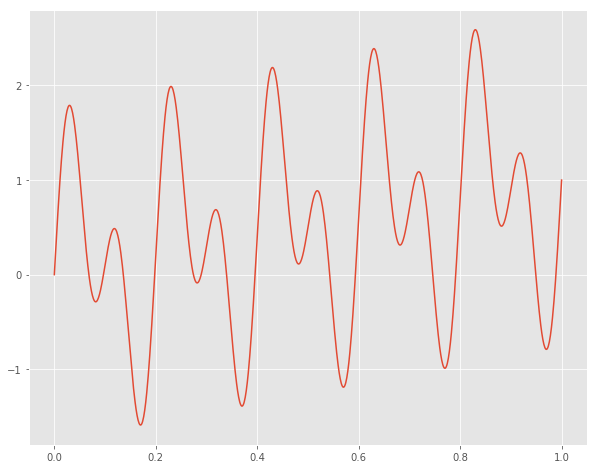

In [11]:
n_points = 1000
f1, f2 = 5, 10
time_samples = np.linspace(0, 1, n_points)
mode1 = np.sin(2 * np.pi * f1 * time_samples)
mode2 = np.sin(2 * np.pi * f2 * time_samples)
trend = time_samples

signal = mode1 + mode2 + trend
plt.figure(figsize=(10, 8))
plt.plot(time_samples, signal)

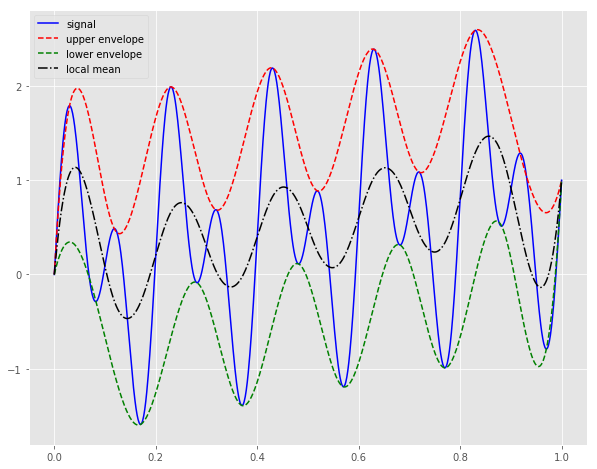

In [12]:
from scipy.signal import argrelmin, argrelmax
from scipy.interpolate import splrep, splev

def get_envelopes(x):
    """Compute the upper and lower envelopes of a signal."""
    maxima = argrelmax(x)[0]
    minima = argrelmin(x)[0]
    x_upper = np.zeros((maxima.shape[0] + 2,))
    x_upper[1:-1] = maxima
    x_upper[-1] = x.shape[0] - 1
    x_lower = np.zeros((minima.shape[0] + 2,))
    x_lower[1:-1] = minima
    x_lower[-1] = x.shape[0] - 1
    tck = splrep(x_upper, x[x_upper.astype(int)])
    upper_envelop = splev(np.arange(x.shape[0]), tck)
    tck = splrep(x_lower, x[x_lower.astype(int)])
    lower_envelop = splev(np.arange(x.shape[0]), tck)
    return upper_envelop, lower_envelop

upper, lower = get_envelopes(signal)
plt.figure(figsize=(10, 8))
plt.plot(time_samples, signal, 'b', label='signal')
plt.plot(time_samples, upper, 'r--', label='upper envelope')
plt.plot(time_samples, lower, 'g--', label='lower envelope')
plt.plot(time_samples, (upper + lower) / 2, "k-.", label="local mean")
plt.legend()

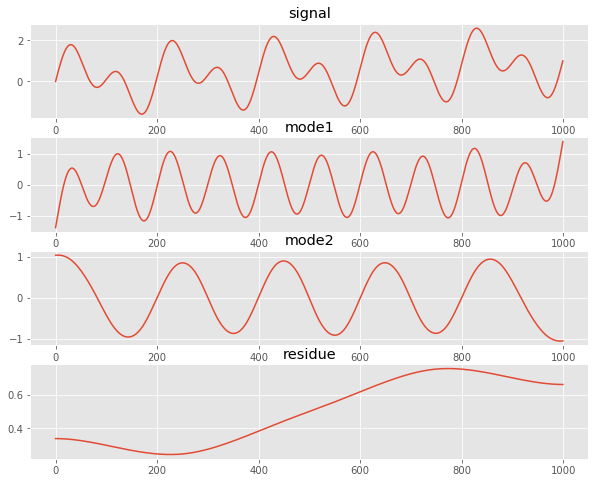

In [13]:
from pyhht.emd import EmpiricalModeDecomposition as EMD
from pyhht.visualization import plot_imfs
engine = EMD(signal, n_imfs=2)
imfs = engine.decompose()
plt.figure(figsize=(10, 8))
plt.subplot(imfs.shape[0] + 1, 1, 1), plt.plot(signal), plt.title("signal")
for i in range(imfs.shape[0]):
    plt.subplot(imfs.shape[0] + 1, 1, i + 2), plt.plot(imfs[i, :])
    if i != imfs.shape[0] - 1:
        plt.title("mode{}".format(i + 1))
    else:
        plt.title("residue")

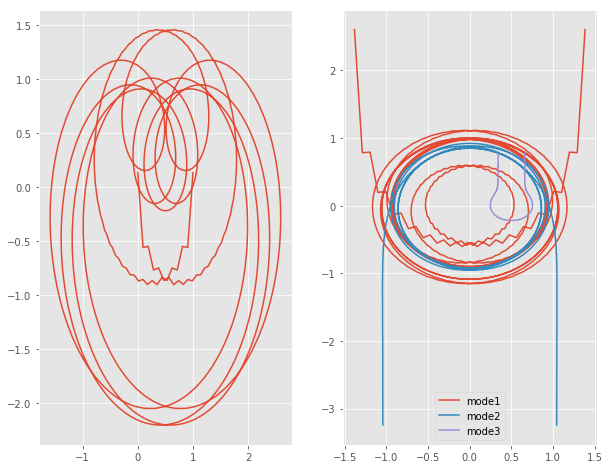

In [14]:
h_signal = hilbert(signal)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.real(h_signal), np.imag(h_signal))
ax = fig.add_subplot(1, 2, 2)
for i in range(imfs.shape[0]):
    h_imf = hilbert(imfs[i, :])
    ax.plot(np.real(h_imf), np.imag(h_imf), label="mode{}".format(i + 1))
ax.legend()

# Gallery Examples

# What PyTFTB Needs
* ## Housekeeping 
[![Documentation Status](https://readthedocs.org/projects/pytftb/badge/?version=master)](http://pytftb.readthedocs.org/en/master/?badge=master)[![Build Status](https://travis-ci.org/scikit-signal/pytftb.svg)](https://travis-ci.org/scikit-signal/pytftb)[![Coverage Status](https://coveralls.io/repos/scikit-signal/pytftb/badge.svg?branch=master&service=github)](https://coveralls.io/github/scikit-signal/pytftb?branch=master)[![Code Health](https://landscape.io/github/scikit-signal/pytftb/master/landscape.svg?style=flat)](https://landscape.io/github/scikit-signal/pytftb/master)
* ## Documentation & Tutorials ([Original Tutorial](http://tftb.nongnu.org/tutorial.pdf))
    - ### Atomic Decompositions - _Linear_ distributions and decompositions
    - ### Energy Distributions - Distribute the _energy_ of signals over time and frequency
    - ### Extracting info fro TF _images_
* ## Test Coverage! (Not for the faint of heart)
* ## GPU backend (Here be Dragons!) & more